In [2]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

In [2]:
%time txes = chain.blocks.txes.where(lambda tx: tx.fee > 10**7).to_list()

%time txes2 = [tx for block in chain for tx in block if tx.fee > 10**7]

CPU times: user 1min 11s, sys: 6.15 s, total: 1min 17s
Wall time: 1min 16s
CPU times: user 10min 10s, sys: 460 ms, total: 10min 10s
Wall time: 10min 13s


In [30]:
from multiprocessing import Pool
import itertools

heu = blocksci.heuristics.is_coinjoin

def is_ww2_cj(tx: blocksci.Tx) -> bool:
    return heu(tx)
                            
def filter_txes_large_fee(startstop):
    start, stop = startstop
    return chain[start:stop].txes.where(is_ww2_cj).select(lambda tx: tx.hash)

with Pool(128) as p:
    %time res = p.map(filter_txes_large_fee, chain._segment_indexes(0, len(chain), 128))


CPU times: user 144 ms, sys: 171 ms, total: 315 ms
Wall time: 2.28 s


In [31]:
r = list(map(lambda t: t.decode(), (itertools.chain(*res))))
print(len(r))
print(r[1])

1211614
8d49d3808c55ddc7d99b2f179f054b72b9c6ba8d4b4b7a4b7c35fc8950ddf45c


In [4]:
%time txes3 = chain.filter_fee_greater_than(0, len(chain), 10**7)

CPU times: user 57 s, sys: 51.3 s, total: 1min 48s
Wall time: 757 ms


In [32]:
%time ww2_cjs = set(map(lambda tx: tx.hash, chain.filter_coinjoin_txes(0, len(chain), "ww2")))

print(len(ww2_cjs))

CPU times: user 1min 19s, sys: 388 ms, total: 1min 19s
Wall time: 604 ms
37528


In [33]:
%time ww1_cjs = set(map(lambda tx: tx.hash, chain.filter_coinjoin_txes(0, len(chain), "ww1")))

print(len(wp))

CPU times: user 17min 46s, sys: 786 ms, total: 17min 47s
Wall time: 28.6 s
541119


In [34]:
%time wp = set(map(lambda tx: tx.hash, chain.filter_coinjoin_txes(0, len(chain), "wp")))

print(len(wp))

CPU times: user 1min 25s, sys: 687 ms, total: 1min 26s
Wall time: 1.12 s
541119


In [42]:
sww2 = set(ww2_cjs)
sww1 = set(ww1_cjs)
swp = set(wp)
srandom = set(r)

print(set.intersection(sww2, sww1, swp, srandom))

set()


In [14]:
print(no_ww2_check[0].inputs[0].address_type == blocksci.address_type.witness_pubkeyhash)

c: blocksci.Address = chain.address_from_string("bc1qa24tsgchvuxsaccp8vrnkfd85hrcpafg20kmjw")

c.output_txes_count()

True


3209

In [19]:
denoms2 = set(
    sorted([
    200000000000, 20000000000, 2000000000, 20000000, 200000, 100000000000, 20000, 10000000000, 1000000000, 10000000, 
    100000, 6561, 59049, 354294, 177147, 10000, 5000, 6973568802, 134375000000, 86093442, 2324522934, 
    3188646, 3486784401, 2000000, 1073741824, 387420489, 8388608, 65536, 19683, 2147483648, 774840978, 
    16777216, 131072, 4294967296, 33554432, 262144, 8589934592, 67108864, 524288, 17179869184, 134217728, 
    8192, 1048576, 100000000, 531441, 268435456, 34359738368, 16384, 2097152, 200000000, 1062882, 1000000, 
    68719476736, 536870912, 32768, 4194304, 1162261467, 1594323, 4782969, 14348907, 43046721, 129140163, 10460353203, 
    31381059609, 94143178827, 13122, 39366, 118098, 9565938, 28697814, 258280326, 20920706406, 62762119218, 188286357654
        ]
    )
)


CPU times: user 9min 48s, sys: 14.8 s, total: 10min 3s
Wall time: 3.39 s


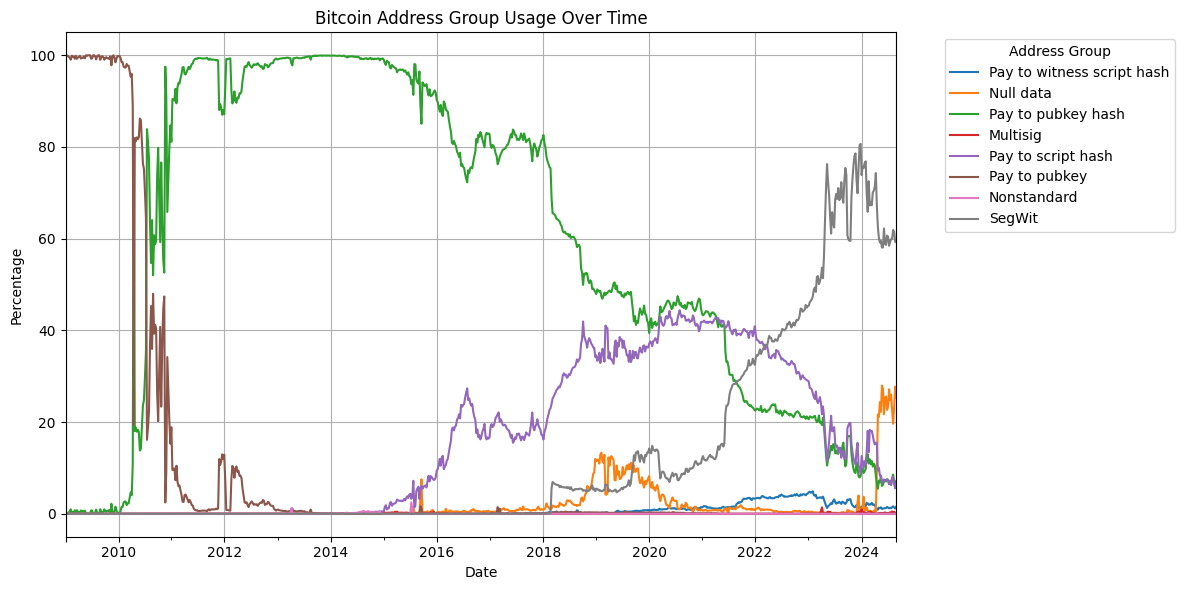

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%time data = chain.get_count_of_address_types_for_each_day(0, len(chain))


# Convert data to a flat DataFrame
df = pd.DataFrame.from_dict(data, orient='index')
df = df.fillna(0).T  # Transpose to make days the rows
df.index = pd.to_datetime(df.index.map(lambda x: datetime.utcfromtimestamp(x * 86400)))

# Define grouping of address types
group_mapping = {
    blocksci.address_type.witness_pubkeyhash: "segwit",
    blocksci.address_type.witness_unknown: "segwit",
    blocksci.address_type.witness_unknown: "segwit",
}

# Aggregate the grouped categories
segwit_total = df[group_mapping.keys()].sum(axis=1)  # Sum up all segwit categories
df["SegWit"] = segwit_total  # Add as a new column

# Drop the original categories that were grouped
df = df.drop(columns=group_mapping.keys())

# Resample to larger bins (e.g., weekly bins)
df = df.resample('W').sum()

# Calculate total transactions per bin
df['total'] = df.sum(axis=1)

# Calculate percentages for each category
percentages = df.div(df['total'], axis=0) * 100
percentages = percentages.drop(columns=['total'])  # Drop the total column

# Plot the data
plt.figure(figsize=(12, 6))
percentages.plot(kind='line', ax=plt.gca())

# Move legend outside the graph
plt.legend(title='Address Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title and labels
plt.title('Bitcoin Address Group Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.grid()

# Adjust layout to accommodate the legend
plt.tight_layout()

# Show the plot
plt.show()
